In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def coth(a):
    if a>0: return (1+tf.math.exp(-2*a))/(1-tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)+1)/(tf.math.exp(2*a)-1)
    if a==0: return 0

def tanh(a):
    if a>0: return (1-tf.math.exp(-2*a))/(1+tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)-1)/(tf.math.exp(2*a)+1)
    if a==0: return 0

In [3]:
data=10000
batch=100
set=100
layer=10
n_ini=1.0
n_fin=0.1
dn=-0.1
c_reg1=0.04
c_reg2=0.0003
d=4

m^2= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.1422364073429916>
lam= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.6241437592589865>
alpha= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.28596691158445775>
beta= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.41044564769146297>
<tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([1.10903771, 2.10712618, 1.30310926, 2.46397148, 1.98438451,
       3.1254203 , 1.03682718, 1.90976603, 2.60573565, 3.07801651])>


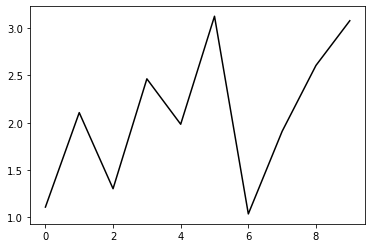

In [18]:
h=tf.zeros(layer)
h_in=[]
for i in range (layer):
    h_inn=np.float64(np.random.normal(2, 1))
    h_in.append(h_inn)
h=tf.Variable(h_in)
m2=tf.Variable(np.float64(np.random.normal(2, 1)))
lam=tf.Variable(np.float64(np.random.normal(1, 1)))
alpha=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
beta=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
#m2=tf.constant(np.float64(5.6))
#lam=tf.constant(np.float64(0.61))
#alpha=tf.constant(np.float64(1.444635))
#beta=tf.constant(np.float64(0.00615))
print("m^2=", m2)
print("lam=", lam)
print("alpha=", alpha)
print("beta=", beta)
print(h)
plt.plot(h.numpy(), 'k-')
plt.show()

In [5]:
def F_func(m, la, a,b):
    return 2*b/n_fin-m*a-la*(a**3)

def t_func(a):
    return 0.5*(tf.math.tanh(100*(a-0.1))-tf.math.tanh(100*(a+0.1))+2)

In [6]:
x=[i*0.2 for i in range (30)]
y=[0.0, 0.018, 0.035, 0.053, 0.0715, 0.0895, 0.107, 0.125, 0.146, 0.1665, 0.1875, 0.2085, 0.229, 0.25, 0.265, 0.281, 0.296, 0.3115, 0.3275, 0.343, 0.3565, 0.385, 0.4375, 0.5, 0.6, 0.675, 0.735, 0.815, 0.865, 0.885]
y[:]=[2*v for v in y]
fp1 = np.polyfit(x, y, 15)
print(fp1)

[ 1.59046394e-05 -6.81729682e-04  1.31412795e-02 -1.50525136e-01
  1.14052774e+00 -6.02241647e+00  2.27455168e+01 -6.20704699e+01
  1.22166922e+02 -1.71187074e+02  1.66428955e+02 -1.07461552e+02
  4.28229887e+01 -9.20544914e+00  9.55260239e-01 -1.30911492e-04]


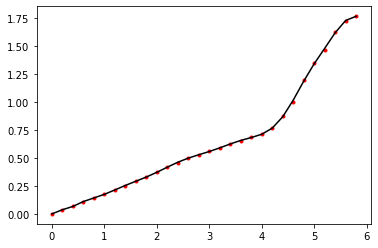

In [7]:
def f(x):
    y=0
    for i in range (16):
        y=y+fp1[i]*x**(15-i)
    return y
yy=[f(i*0.2) for i in range (30)]
plt.plot(x, y, 'r.')
plt.plot(x, yy, 'k-')
plt.show()

In [8]:
def NN_func_p(f):
    Positive=[]
    append=Positive.append
    while len(Positive)<batch:
        H=np.random.uniform(0.0, 6.0)
        M=np.random.uniform(0.0, 2.0)
        noise=np.abs(np.random.normal(0, 0.1))
        if np.abs(M-f(H))<=noise: append([H, M])
        else: continue
    return Positive
def NN_func_n(f):
    Negative=[]
    append=Negative.append
    while len(Negative)<batch:
        H=np.random.uniform(0.0, 6.0)
        M=np.random.uniform(0.0, 2.0)
        noise=np.abs(np.random.normal(0, 0.1))
        if np.abs(M-f(H))>noise: append([H, M])
        else: continue
    return Negative

In [9]:
Positive=[]
Negative=[]
for i in range (set):
    Positive.insert(i, NN_func_p(f))
    Negative.insert(i, NN_func_n(f))

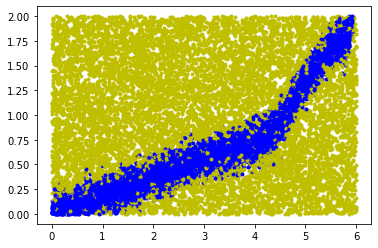

In [10]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive[i]])
    y_data1.insert(i, [v[1] for v in Positive[i]])
    x_data2.insert(i, [v[0] for v in Negative[i]])
    y_data2.insert(i, [v[1] for v in Negative[i]])
    plt.plot(x_data2[i], y_data2[i], 'y.')
    plt.plot(x_data1[i], y_data1[i], 'b.')
plt.show()

In [11]:
def Dfunc(hh, m):
    D=tf.math.sqrt(tf.math.abs(1+4*m/(hh[0]**2)))
    return D

In [12]:
def LP2(hh, m, la, alpha, beta, HH, MM):
    D=Dfunc(hh, m)
    phi=alpha*HH+beta*MM
    pi=(d/2)*(D-1)*alpha*HH+(d/2)*(-D-1)*beta*MM
    for j in range (layer-1):
        phi1=phi+dn*pi
        pi1 =phi*m*dn+(1-dn*hh[j])*pi+dn*la*(phi1**3)
        phi=phi1
        pi=pi1
    return phi, pi
def NN_func_01(hh, m, la, alpha, beta, list_hr):
    PP=[]
    NN=[]
    H=np.array(list_hr)[:, 0]
    M=np.array(list_hr)[:, 1]
    F=np.array(tf.math.abs(LP2(hh, m, la, alpha, beta, H, M)[1]))
    for i in range (len(H[F<0.1])):
        PP.append([H[F<0.1][i], M[F<0.1][i]])
    for i in range (len(H[F>=0.1])):
        NN.append([H[F>=0.1][i], M[F>=0.1][i]])
    return PP, NN

In [13]:
Positive0=[]
Positive1=[]
Negative0=[]
Negative1=[]
for i in range (set):
    Positive0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[0])
    Positive1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[1])
    Negative0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[0])
    Negative1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[1])

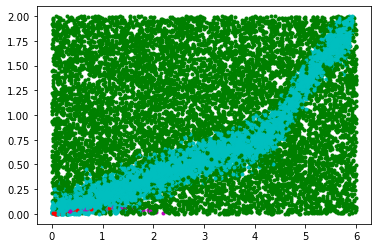

In [14]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
x_data3=[]
y_data3=[]
x_data4=[]
y_data4=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive0[i]])
    y_data1.insert(i, [v[1] for v in Positive0[i]])
    x_data2.insert(i, [v[0] for v in Positive1[i]])
    y_data2.insert(i, [v[1] for v in Positive1[i]])
    x_data3.insert(i, [v[0] for v in Negative0[i]])
    y_data3.insert(i, [v[1] for v in Negative0[i]])
    x_data4.insert(i, [v[0] for v in Negative1[i]])
    y_data4.insert(i, [v[1] for v in Negative1[i]])
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()

# Error function

$E=\sum_{data} \left\vert y(\bar{x}^{(1)}) - \bar{y} \right\vert+E_{reg}(W)$
, $E_{reg}=c_{reg}^{(1)}\sum_{n=1}^{N-1}(\eta^{(n)})^{4}(h(\eta^{(n+1)})-h(\eta^{(n)}))^{2}+c_{reg}^{(2)}(h(\eta^{(N)})-1/\eta^{(N)})^{2}$

In [15]:
def Error_func(hh, m, la, alpha, beta, list1, list2):
    H0=np.array([v[0] for v in list1])
    M0=np.array([v[1] for v in list1])
    H1=np.array([v[0] for v in list2])
    M1=np.array([v[1] for v in list2])
    H_0, M_0=LP2(hh, m, la, alpha, beta, H0, M0)
    H_1, M_1=LP2(hh, m, la, alpha, beta, H1, M1)
    PPlist=t_func(M_0)
    NNlist=t_func(M_1)
    sum_p=sum(PPlist)/batch
    sum_n=(batch-sum(NNlist))/batch

    inside=0
    for k in range (layer-1):
        second=((n_ini+k*dn)**4)*((hh[k+1]-hh[k])**2)
        inside=inside+second
    E_reg1=c_reg1*inside
    E_reg2=c_reg2*((hh[layer-1]-1/n_fin)**2)
    return sum_n+sum_p+E_reg1+E_reg2

In [16]:
for i in range (set):
    print(Error_func(h, m2, lam, alpha, beta, Positive[i], Negative[i]))

tf.Tensor(1.064274112672678, shape=(), dtype=float64)
tf.Tensor(1.0342783477299604, shape=(), dtype=float64)
tf.Tensor(1.0513867584257954, shape=(), dtype=float64)
tf.Tensor(1.0542736650363318, shape=(), dtype=float64)
tf.Tensor(1.054274170878962, shape=(), dtype=float64)
tf.Tensor(1.0442072279491867, shape=(), dtype=float64)
tf.Tensor(1.0460442309575957, shape=(), dtype=float64)
tf.Tensor(1.0340863492277934, shape=(), dtype=float64)
tf.Tensor(1.0442741719902338, shape=(), dtype=float64)
tf.Tensor(1.0442735755187031, shape=(), dtype=float64)
tf.Tensor(1.0235404319199508, shape=(), dtype=float64)
tf.Tensor(1.0338891853433814, shape=(), dtype=float64)
tf.Tensor(1.0384146375031778, shape=(), dtype=float64)
tf.Tensor(1.036013761279031, shape=(), dtype=float64)
tf.Tensor(1.0542717002090634, shape=(), dtype=float64)
tf.Tensor(1.0442695297950555, shape=(), dtype=float64)
tf.Tensor(1.0227268651701185, shape=(), dtype=float64)
tf.Tensor(1.0442741712809311, shape=(), dtype=float64)
tf.Tensor(1.0

KeyboardInterrupt: 

# Optimize

100 1.117895405335407
0.13723669478815573 0.6191545011838558 0.2809672914110631 0.41544442772889156
[1.11403762 2.10212624 1.30810916 2.45897165 1.98938413 3.12042065
 1.04182652 1.90477118 2.60074929 3.08301457]


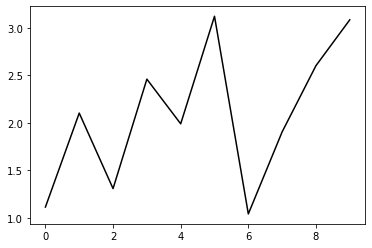

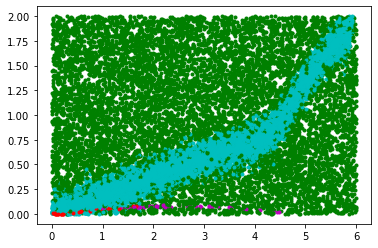

10100 1.0190055809336083
0.07433667378183212 0.6584285096505048 0.2996419469439511 0.39645726149606497
[1.2621465  1.71057126 1.65632553 2.09338626 2.25755285 2.69585081
 1.45940518 1.62927633 2.31564535 3.57211437]


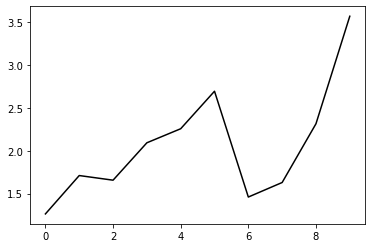

20100 1.0045799695909159
0.09428087622329288 0.6609329097193233 0.3141145891104139 0.31682311690773046
[1.31403543 1.52836544 1.71191512 1.93812571 2.14240325 2.38473397
 1.74910721 1.5931105  2.11974548 4.0436229 ]


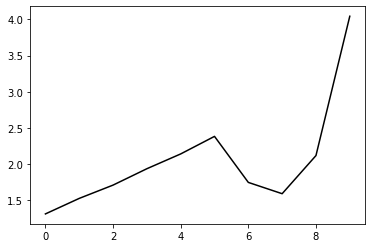

30100 0.974588106857763
0.07697585089180331 0.7015620719730464 0.36594478953404663 0.20309641763867298
[1.36878237 1.47225041 1.6126138  1.7745604  1.91845074 2.11136921
 1.8542247  1.60412988 1.95433841 4.50217874]


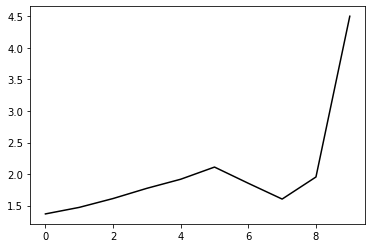

40100 0.8143778514471839
0.16058238006750067 0.5109072737879987 0.09255795283212864 0.041261317242696105
[1.31947869 1.38076258 1.45729265 1.52859368 1.59742119 1.70753437
 1.48376612 1.12005737 1.39689026 4.94640673]


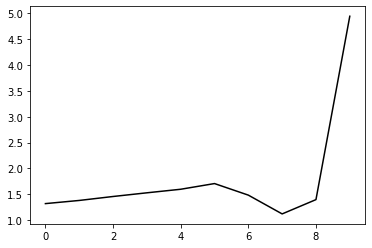

50100 0.38542520508631156
0.1917797667365953 0.39446462113796465 0.08765830959585019 0.033197968367010625
[1.29132001 1.32725042 1.3849261  1.44517506 1.50447938 1.55603289
 1.37810218 1.02287541 1.26656825 5.381628  ]


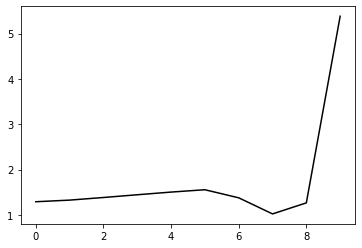

60100 0.4317722242487779
0.2008083930009402 0.30020547899217553 0.08249325572264417 0.04050857927168645
[1.28592463 1.29382458 1.33446412 1.38309388 1.43258545 1.4591244
 1.31076789 0.97340149 1.1967374  5.80983601]


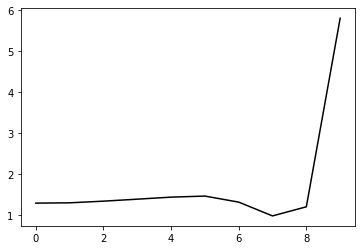

70100 0.39454091679358877
0.21744174182958667 0.13389248888410576 0.08648089317245902 0.038882039689447215
[1.2714838  1.29283291 1.31847971 1.34886543 1.38461449 1.39562785
 1.2648949  0.94457515 1.15285104 6.22792877]


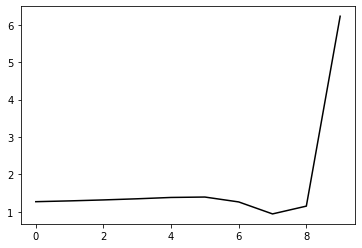

80100 0.48174058030987854
0.21080856247016125 -0.0005364450792821515 0.0851847502550846 0.040162723277000587
[1.27853782 1.25084385 1.24856921 1.26245615 1.28284805 1.28113038
 1.16262176 0.86129101 1.0590879  6.63379147]


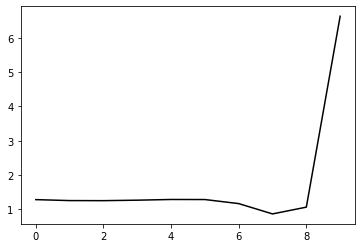

90100 0.4489945318066539
0.2139094422527422 -0.1596188309722634 0.10623483310099256 0.036709228396941976
[1.2751981  1.22169365 1.19825007 1.19048333 1.19149591 1.17653114
 1.06677601 0.78688396 0.9780756  7.02257804]


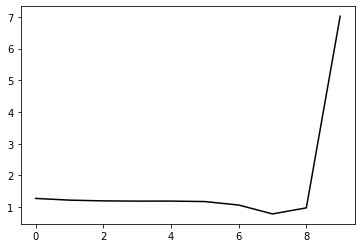

100100 0.16439357362382487
0.1569484760093092 -0.41036660255659446 0.13842113724363464 0.05203437450794522
[1.315904   1.13902578 1.02648055 0.97396596 0.95158037 0.92472565
 0.82057816 0.56161014 0.75873649 7.38284691]


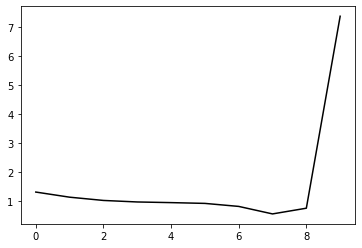

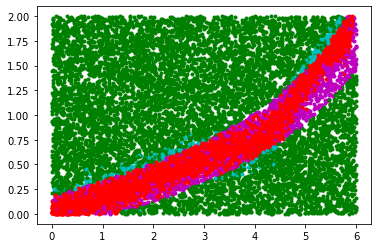

110100 0.19434276352101218
0.15412214622066608 -0.42552852486392806 0.14305077348407674 0.05664266059266172
[1.31468944 1.19931297 1.06806145 0.9582778  0.8922662  0.84455014
 0.74029486 0.49743516 0.69746978 7.70705852]


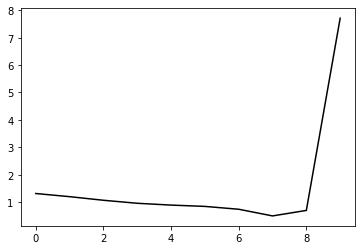

120100 0.28406128892416055
0.1566428172023019 -0.432022660152895 0.147804228373781 0.057534993777470095
[1.30986471 1.19871904 1.06594095 0.936991   0.83141437 0.7522652
 0.6410813  0.41226941 0.61665956 7.9827224 ]


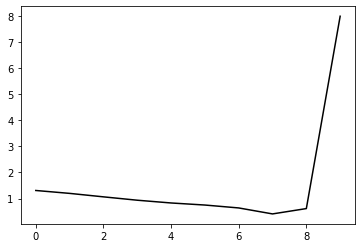

130100 0.18546601044142405
0.16813881295778427 -0.4227493939317564 0.1462164102744717 0.05776967248916347
[1.29972673 1.2133986  1.09017106 0.94991595 0.81836113 0.70973727
 0.58573698 0.36462887 0.57103911 8.18318973]


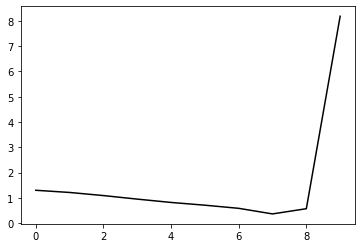

140100 0.4107345977905803
0.17366515635486512 -0.42587260756137346 0.15094330466026493 0.0520677192753493
[1.29114112 1.19491858 1.07828047 0.93907827 0.79173238 0.65529104
 0.51522509 0.30337043 0.5178338  8.29595701]


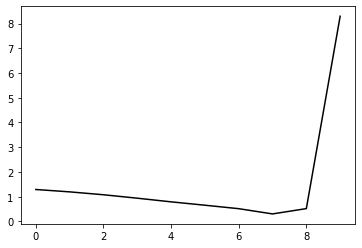

150100 0.22001555136185683
0.1778675986089092 -0.41689697278237275 0.14634732369032402 0.06136294687456983
[1.28838998 1.20534346 1.08109745 0.92905654 0.76619894 0.60622968
 0.4465466  0.23620895 0.45510046 8.31816724]


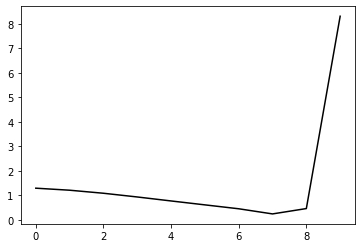

160100 0.23217009414543005
0.1803424786687889 -0.4136186953924036 0.14718450149780807 0.062270642279792024
[1.28478929 1.19402055 1.06631689 0.91003159 0.73629914 0.55815226
 0.3808379  0.17017496 0.39326817 8.31127891]


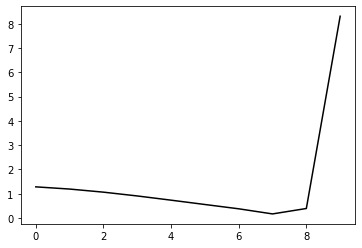

170100 0.4675323539876543
0.1686970067693455 -0.4132163110507334 0.14428267391755956 0.07308292263440448
[1.29240589 1.16662169 1.02995635 0.87000353 0.6870422  0.49154107
 0.29546666 0.08247094 0.31080549 8.30243782]


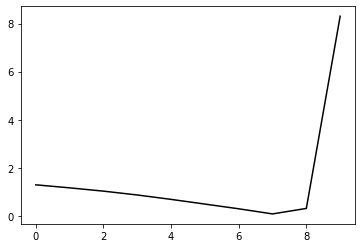

180100 0.21276090367136516
0.18103103780025842 -0.4148752019949946 0.15117956496993434 0.06786148807424974
[1.27932351 1.17431027 1.03969406 0.87253589 0.68056126 0.47274083
 0.26217388 0.04672325 0.28083732 8.29140777]


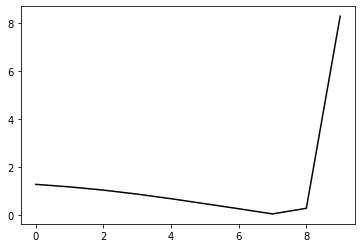

190100 0.2166904755881968
0.1897144611538797 -0.4074937719315513 0.1511180746408534 0.06836995313361433
[ 1.27212010e+00  1.17118356e+00  1.03320423e+00  8.64416725e-01
  6.65132520e-01  4.43854115e-01  2.16644768e-01 -5.53005349e-03
  2.30468198e-01  8.28171602e+00]


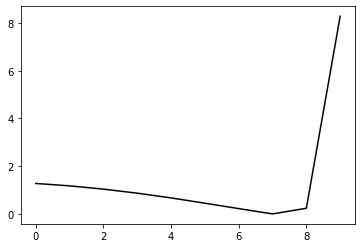

200100 0.24520630219810818
0.19132501161147994 -0.4010040218992573 0.14931644551924536 0.0687076277190922
[ 1.26806219  1.1723521   1.03925856  0.86814583  0.6632532   0.43115644
  0.18925766 -0.03874312  0.20183766  8.27722796]


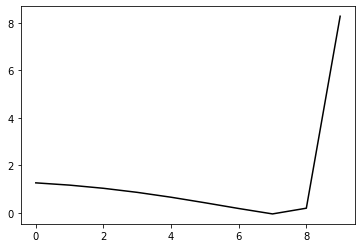

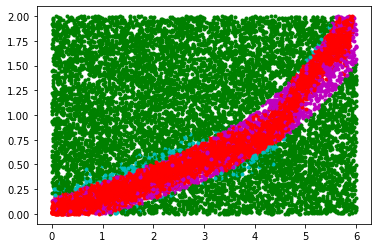

210100 0.22541293425514428
0.18817023844374905 -0.40232886302524123 0.15133051413398554 0.07145282521859181
[ 1.2681286   1.13626621  0.98581101  0.80907742  0.5956476   0.34940212
  0.08880982 -0.15067646  0.09025049  8.25728298]


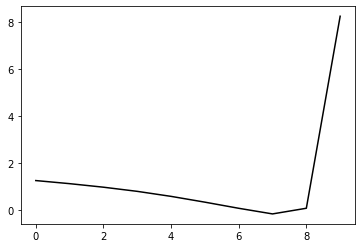

220100 0.29258990176550365
0.1904758202805667 -0.39871596165471657 0.15129589190241777 0.08146590508369457
[ 1.26623491  1.13909697  1.00175952  0.82366874  0.60457241  0.34921265
  0.07577913 -0.17041914  0.0763766   8.25608909]


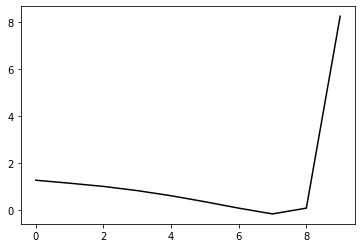

230100 0.17616061590672982
0.207575646383046 -0.3877282928113373 0.15278443828644442 0.07454203044558265
[ 1.25226539  1.15618948  1.01633598  0.8338814   0.60954204  0.3446558
  0.0568823  -0.20045247  0.04586386  8.2494874 ]


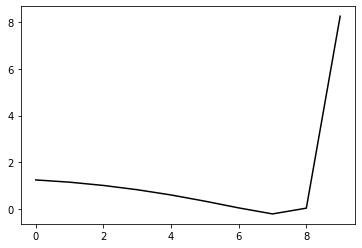

240100 0.22851766294751086
0.2014057649938009 -0.3883584588059081 0.15450584675939108 0.0767929896367285
[ 1.25312788  1.15023103  1.01675764  0.83924693  0.61473765  0.34412918
  0.04543618 -0.21956941  0.03252445  8.24800993]


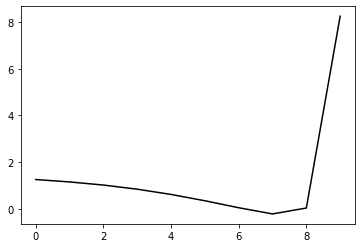

250100 0.16283344941163858
0.20384569346286827 -0.38505223612113815 0.1566338196599552 0.0772055772789241
[ 1.24921664e+00  1.14531303e+00  1.00415655e+00  8.20714532e-01
  5.92907581e-01  3.15811248e-01  5.40263839e-03 -2.70245976e-01
 -1.73102414e-02  8.23940058e+00]


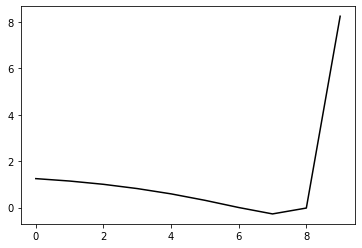

260100 0.2426891803207559
0.19880364635162132 -0.38469882084239015 0.1582092481126011 0.0748464216062596
[ 1.24824533  1.13719761  0.99478247  0.8159155   0.58790251  0.30670435
 -0.01290911 -0.2976216  -0.0412839   8.23394906]


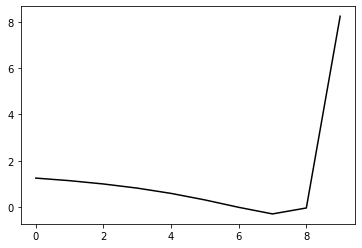

270100 0.27175604328971836
0.20811463941170846 -0.37301575660163416 0.15668598875410977 0.07666834340614599
[ 1.24160033  1.14786054  1.01033629  0.83110832  0.60220884  0.31652177
 -0.013118   -0.30923475 -0.05290572  8.23315547]


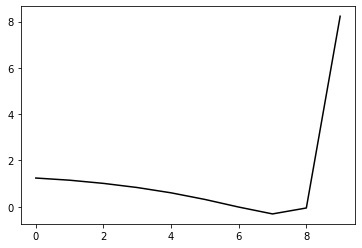

280100 0.18518946157243377
0.20029289039923856 -0.37143238682036184 0.15667694775963073 0.08295254809994254
[ 1.24536095  1.13160855  0.99029125  0.811148    0.58179555  0.2921216
 -0.04667334 -0.35384269 -0.09758406  8.22599788]


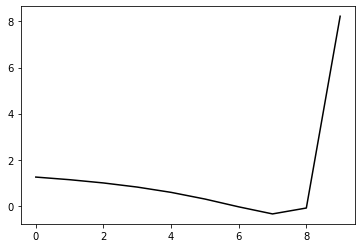

290100 0.22221155366662831
0.20385839410736983 -0.366480582414366 0.15864909348386066 0.07686280082357796
[ 1.23872582  1.13193758  0.9894828   0.80591931  0.57427582  0.28137223
 -0.06559944 -0.3839046  -0.12879379  8.21904828]


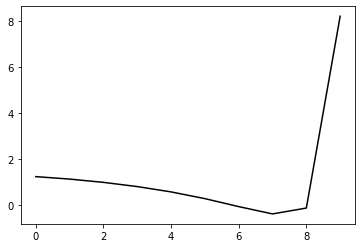

300100 0.22959851227686148
0.20053087653868498 -0.3616576412955381 0.1586110698853605 0.08514964129403985
[ 1.24102168  1.13079322  0.99399992  0.81274271  0.57957608  0.28403807
 -0.06881492 -0.39565957 -0.13983686  8.21724546]


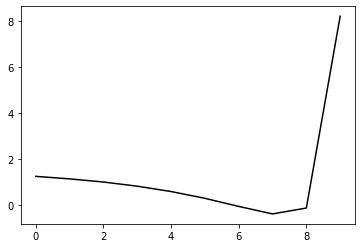

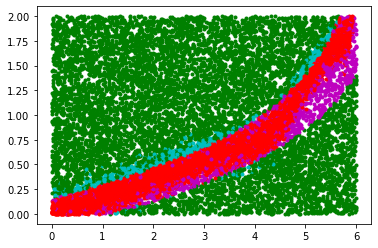

310100 0.18703114815374783
0.20658136098344668 -0.3566802929316836 0.16342603545003134 0.0774350760226084
[ 1.23277786  1.13759454  1.00152636  0.821574    0.59009659  0.29360676
 -0.06440296 -0.40043344 -0.14588581  8.21665413]


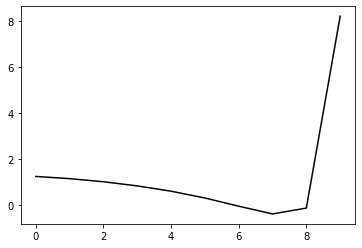

320100 0.28850766004304396
0.20463871809798345 -0.3487883615494889 0.16077131889466278 0.0800063178289685
[ 1.23356174  1.13123507  0.98114538  0.79661549  0.56154303  0.25998877
 -0.10664783 -0.45497915 -0.20522568  8.20680929]


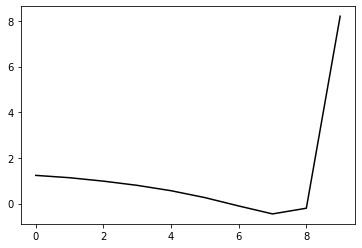

330100 0.21610498018935895
0.20733735418952295 -0.34396759039972596 0.1610673869505458 0.08358235610682911
[ 1.23051436  1.13180567  0.98926272  0.80525113  0.56795818  0.26311331
 -0.10926168 -0.46639397 -0.21819639  8.20269086]


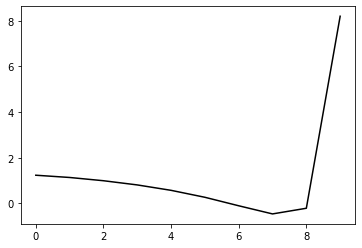

340100 0.1784844663636999
0.20461676630114886 -0.33883853133236713 0.16126607230577109 0.08185774332128455
[ 1.22909017  1.13324127  0.99738383  0.81690978  0.58112946  0.27558174
 -0.10045224 -0.46463808 -0.21688545  8.20066129]


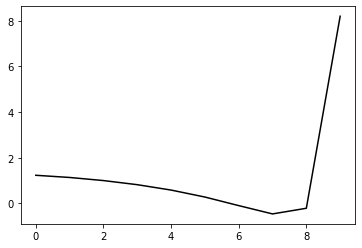

350100 0.2686648564595175
0.20153474955413875 -0.3396881024225596 0.16485009458306948 0.0861364356809228
[ 1.22884129  1.1196891   0.98883551  0.81066753  0.57545247  0.26848255
 -0.11205282 -0.48405639 -0.23682616  8.20096866]


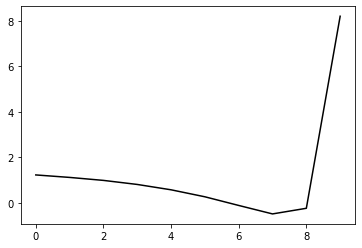

360100 0.22962091805937238
0.20067093537144226 -0.3328804174782842 0.1656186254504916 0.08036651408943407
[ 1.22641941  1.1147499   0.97741523  0.79842265  0.5648863   0.25773132
 -0.12695543 -0.50768766 -0.2643353   8.1962717 ]


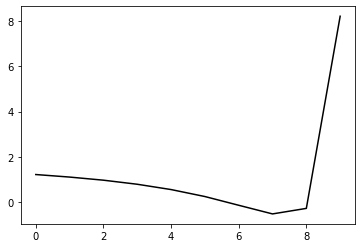

370100 0.1800786009948965
0.20778374498069885 -0.3284015404914616 0.16776469369285724 0.08132379039665037
[ 1.22002859  1.11851136  0.96795323  0.78033119  0.54179739  0.23096411
 -0.15963748 -0.54990022 -0.31105506  8.1873619 ]


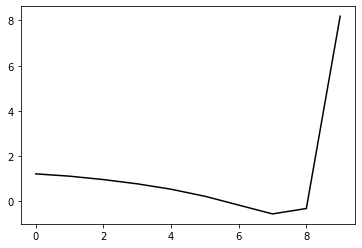

380100 0.2112398980464872
0.21283841137807544 -0.3183864698841125 0.16560007977556865 0.08543649371718567
[ 1.21576034  1.13690569  0.9973263   0.80701503  0.56383532  0.25021165
 -0.14371184 -0.54016293 -0.3028131   8.18877467]


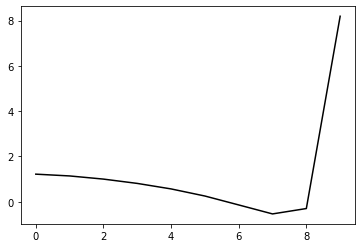

390100 0.17311809559987756
0.20129425625428035 -0.3217593909675613 0.16783294939517565 0.09083975851507262
[ 1.22129584  1.11857985  0.98152481  0.79275624  0.54802353  0.23130842
 -0.16644082 -0.56932029 -0.3338026   8.18369698]


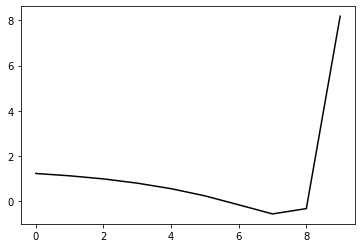

400100 0.15041395715685055
0.20646588417644648 -0.3138374767323787 0.167724481779134 0.08378553073199242
[ 1.21421784  1.11283635  0.97657409  0.79319268  0.54910906  0.22875931
 -0.17468449 -0.58638645 -0.35618074  8.17909177]


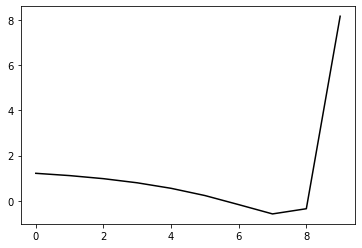

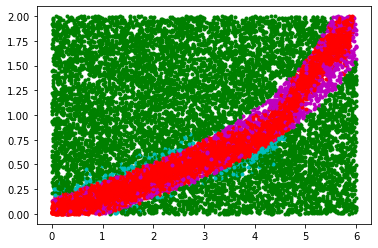

410100 0.20696386489013507
0.1955276303590299 -0.3164622061595957 0.17107716774493822 0.0907838025105539
[ 1.22007734  1.10667665  0.96737674  0.7873146   0.54840655  0.2297089
 -0.17576169 -0.59264534 -0.36353851  8.17731409]


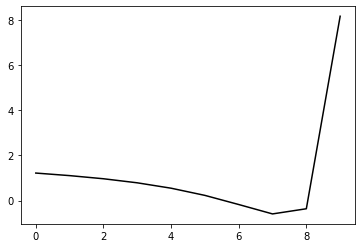

420100 0.18852442552131216
0.1940431008806148 -0.3134001083481042 0.17173832419495028 0.09158065493653932
[ 1.21920349  1.10011414  0.95779232  0.77333893  0.53256508  0.21296275
 -0.19636248 -0.62055928 -0.39568638  8.1749333 ]


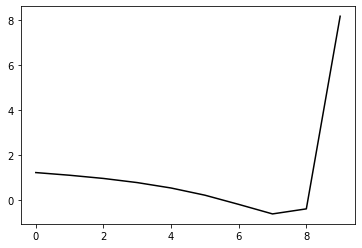

430100 0.21065276392155613
0.202571403605909 -0.2981540610750125 0.1701030848260114 0.08648009085237056
[ 1.21258422  1.10792072  0.96829958  0.78393751  0.54166906  0.22068424
 -0.1924477  -0.62490845 -0.40712987  8.17046871]


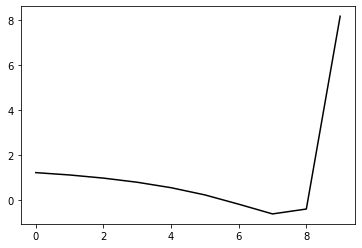

440100 0.22835714948072489
0.20195818785241354 -0.2962201337947602 0.17299639524753782 0.08264278339503427
[ 1.20927397  1.11201334  0.97213489  0.78783877  0.54550943  0.22386968
 -0.19169459 -0.6303253  -0.4166238   8.16893035]


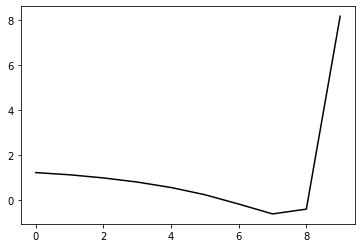

450100 0.18820739886991453
0.19627283591294542 -0.2946523546119247 0.17477601517351335 0.08695493515560021
[ 1.21178494  1.10696006  0.9699198   0.7880635   0.54708989  0.22547655
 -0.1918498  -0.63573371 -0.42545132  8.16934934]


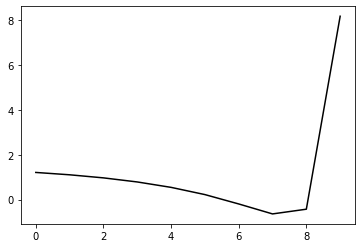

460100 0.21440317495134548
0.19028478007999095 -0.2919973087825852 0.17334674462711133 0.09292372529736487
[ 1.21496082  1.09845069  0.95855317  0.77443461  0.53236879  0.20923401
 -0.21107106 -0.66082593 -0.45457451  8.16292539]


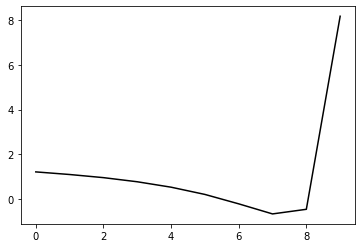

470100 0.14380433862315786
0.18602061595285957 -0.29797442800978124 0.1789953520794563 0.09101963345572088
[ 1.21340691  1.07960389  0.93152605  0.74734035  0.50408565  0.17890921
 -0.2446418  -0.70046593 -0.49877414  8.15452145]


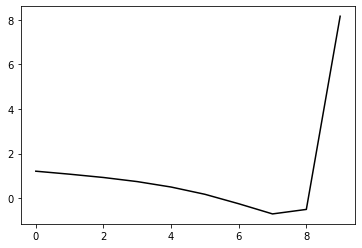

480100 0.26207972894592024
0.19047799223513956 -0.2919916277648399 0.17984729296465202 0.09269351249132693
[ 1.20992312  1.08873317  0.95252651  0.76763652  0.52371045  0.19805434
 -0.22735235 -0.68809828 -0.49125316  8.15502894]


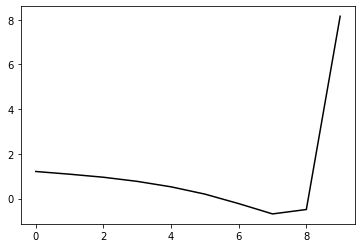

490100 0.1994446443446343
0.19015283694122545 -0.28760978761633604 0.1805913406425153 0.0921737654620708
[ 1.20800829  1.09342687  0.95664469  0.77435441  0.53199327  0.20649686
 -0.22018374 -0.68510036 -0.49247889  8.15622489]


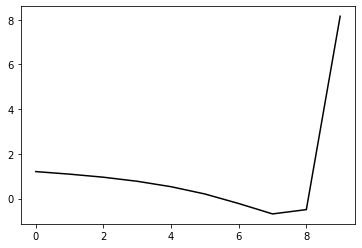

500100 0.1765011779651168
0.18470596699239739 -0.28334033418094684 0.17960420591717952 0.09446601267842875
[ 1.21028713  1.09161623  0.95381044  0.7692804   0.52666448  0.20102634
 -0.22743509 -0.69718999 -0.50991668  8.1527173 ]


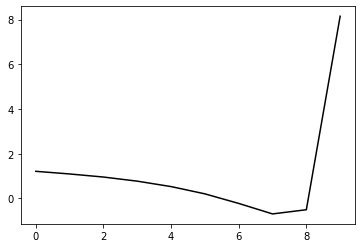

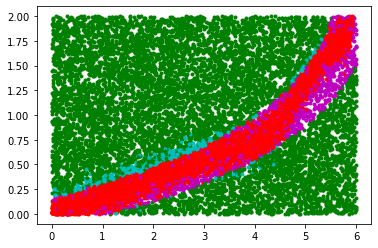

510100 0.19760398654460795
0.18927162423333732 -0.27638759137718466 0.1799550399055831 0.09322447180139798
[ 1.20498025  1.1073462   0.97587551  0.79548538  0.55423825  0.22937929
 -0.19923448 -0.67169458 -0.48730138  8.15777756]


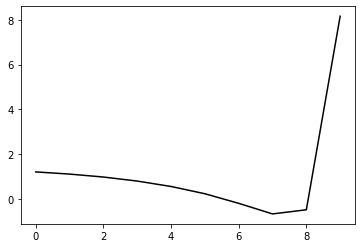

520100 0.2556101838031938
0.18220266059961152 -0.27498563854712516 0.17886583707713336 0.09479219823711103
[ 1.20779145  1.09277126  0.9561676   0.77248594  0.52996753  0.20355374
 -0.22797176 -0.7060312  -0.52766732  8.15103803]


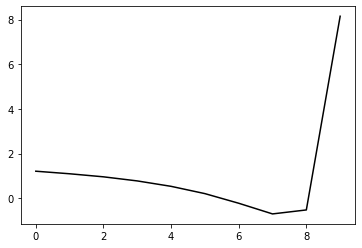

530100 0.1749193645956181
0.18870185265137251 -0.2690823387495704 0.17911643025102844 0.08715863473304496
[ 1.19942305  1.09377011  0.95459269  0.77251649  0.52870929  0.19981143
 -0.23526754 -0.71951006 -0.54816346  8.14373904]


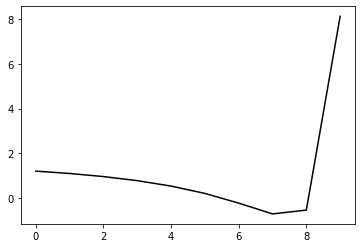

540100 0.17304725153869877
0.1928465558898453 -0.2664518016449065 0.18254640726685525 0.0887815000046572
[ 1.19527915  1.10081054  0.9618794   0.7765353   0.53241575  0.20344048
 -0.23297687 -0.72100111 -0.55416652  8.1425559 ]


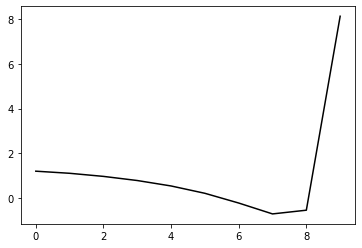

550100 0.18282629507977455
0.1871233580798357 -0.2640035348315513 0.18337648339900214 0.08874363407840447
[ 1.19741054  1.09428151  0.95613341  0.77472979  0.53243052  0.20441342
 -0.23220282 -0.72302235 -0.56031195  8.14232644]


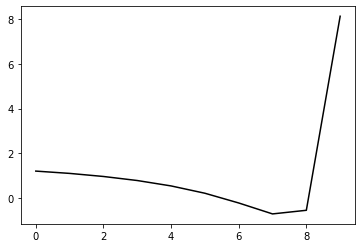

560100 0.3096009800824557
0.17623878988899835 -0.26187376899207165 0.18076957123176926 0.09735782075916231
[ 1.20476923  1.07586353  0.94085435  0.75621823  0.51152168  0.18200678
 -0.25682636 -0.75189054 -0.59426826  8.13783678]


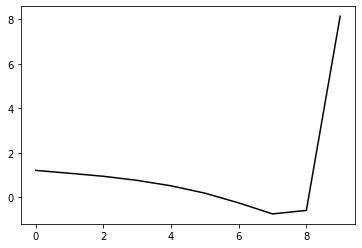

570100 0.18262360313599738
0.18291598590631286 -0.2582627331527893 0.18311883470283116 0.09702927893317675
[ 1.19866774  1.09810209  0.96434114  0.7788524   0.53291418  0.20244187
 -0.23764151 -0.7359303  -0.58262052  8.13893309]


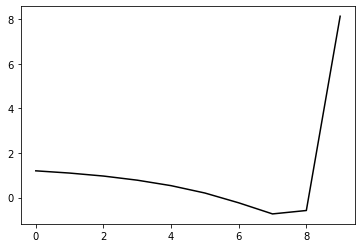

580100 0.1553033091060497
0.19076856096517963 -0.2565928704059696 0.18711438519274828 0.09323215014680886
[ 1.19047928  1.1048733   0.96970376  0.78369508  0.53691676  0.20430084
 -0.23853275 -0.74139191 -0.59381104  8.13595661]


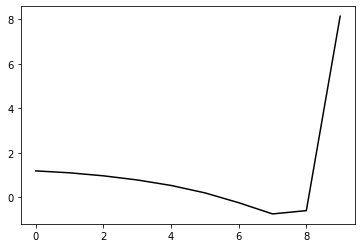

590100 0.19937641393740624
0.18326510490742554 -0.2567976508035008 0.18698473687589057 0.09218912826367925
[ 1.19326625  1.08124576  0.94043184  0.75563769  0.50858007  0.17389272
 -0.2722763  -0.78031812 -0.63900932  8.13068895]


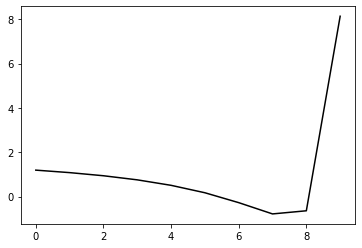

600100 0.23360463373813037
0.1827651322018563 -0.25210552717567924 0.1870232454183648 0.09678009497446874
[ 1.19246475  1.09754378  0.96057761  0.77344443  0.52639627  0.19228272
 -0.25456252 -0.76520162 -0.6277172   8.12924594]


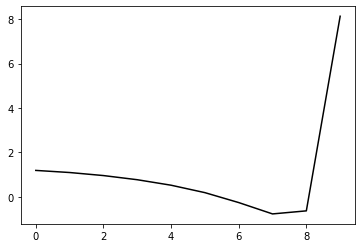

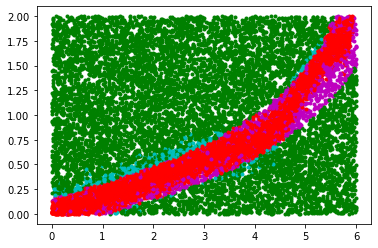

610100 0.3086370328433432
0.18203222112961434 -0.24676566687695534 0.18635838760313522 0.09862185031195747
[ 1.19246051  1.09057041  0.95324031  0.76715001  0.51979906  0.18462584
 -0.26433452 -0.77919523 -0.64747857  8.13035864]


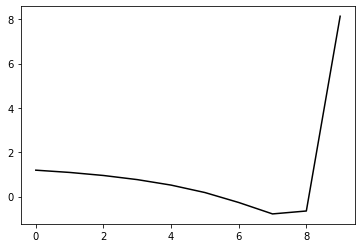

620100 0.26984311722090687
0.18780901162771688 -0.2417313766234252 0.18757052355538384 0.09250839007739949
[ 1.18541647  1.08128053  0.94586502  0.76319473  0.51580415  0.17898647
 -0.27262787 -0.7920444  -0.66652004  8.12270864]


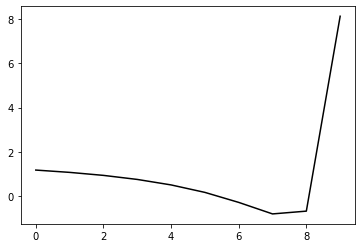

630100 0.2343877426583779
0.1811680201221581 -0.24186431659297292 0.18770264236633719 0.09945214657730951
[ 1.18921845  1.08767405  0.94798856  0.75740105  0.50801907  0.17078313
 -0.28222393 -0.80449901 -0.68258422  8.1212416 ]


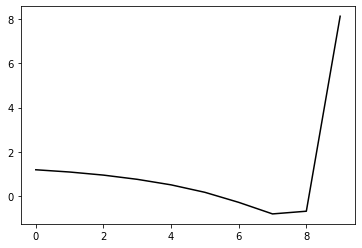

640100 0.20183149147085455
0.1871165055949259 -0.24084200646182108 0.19088144182911046 0.09725868211743836
[ 1.18380655  1.08012992  0.94057504  0.7505589   0.49900795  0.15924866
 -0.2964661  -0.82308717 -0.70699898  8.11985271]


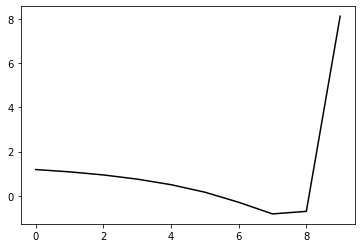

650100 0.238509834821107
0.18570446809829175 -0.2347028601640195 0.18856215535609872 0.09890490025100274
[ 1.18381975  1.0802278   0.94522401  0.75888359  0.50810488  0.16760627
 -0.28944173 -0.81881593 -0.70685012  8.11793275]


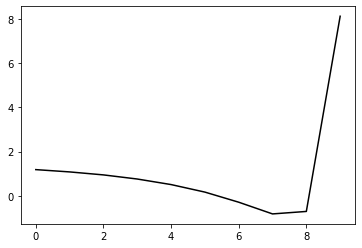

660100 0.2213053450290413
0.1847823334225909 -0.23608690804985713 0.1927394580555033 0.10042514640942617
[ 1.18290149  1.08249222  0.94857013  0.76545646  0.517331    0.17806832
 -0.2790058  -0.80981634 -0.70046241  8.11934947]


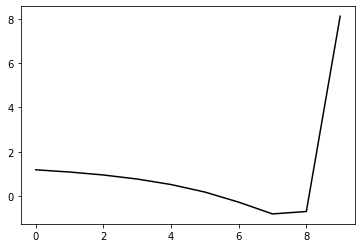

670100 0.18558549422531195
0.1840403775314553 -0.23234439973203785 0.19257200044278602 0.09622388407969831
[ 1.18081687  1.07728836  0.93647612  0.75067423  0.50315095  0.16355953
 -0.29586987 -0.8312524  -0.72844594  8.11398553]


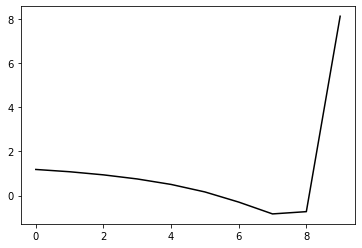

680100 0.19616310713054322
0.18183511846648212 -0.22609319092306923 0.19134541322779802 0.09597547162855503
[ 1.18063549  1.08349459  0.94330648  0.75649723  0.50891406  0.17038954
 -0.28933127 -0.82759639 -0.72998231  8.11324493]


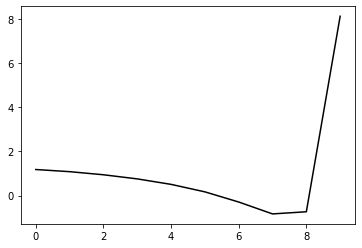

690100 0.17200986130316354
0.17131111840996524 -0.233759080766988 0.19613021758207677 0.09946238678220776
[ 1.18571511  1.05663675  0.92296626  0.74200794  0.49610023  0.15850571
 -0.30074933 -0.84045729 -0.74592236  8.11015519]


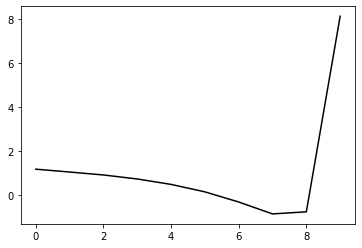

700100 0.22904325198159367
0.17468155363549387 -0.22692300169723853 0.19482234246556873 0.09710958056685222
[ 1.18266803  1.06840835  0.92575667  0.74183728  0.49604643  0.15819789
 -0.30253948 -0.84609854 -0.75816219  8.10574011]


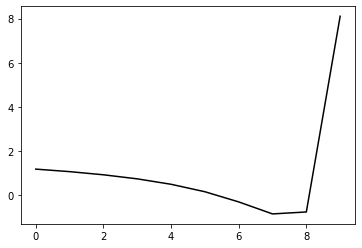

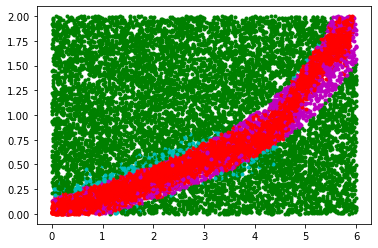

710100 0.34145824688260445
0.1837611344431151 -0.22316631361587555 0.19755189017425298 0.08787658902311932
[ 1.17241422  1.06360584  0.93229796  0.75202971  0.50609953  0.16784999
 -0.29370165 -0.83980808 -0.75642333  8.10788561]


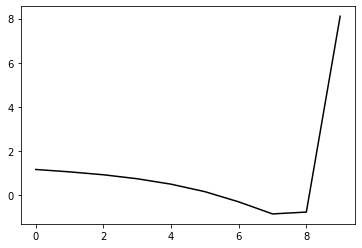

720100 0.21786532164729994
0.16753793879647583 -0.22717801564531756 0.1961006533568403 0.1009804913890955
[ 1.18414035  1.06007449  0.9179369   0.72950058  0.48246002  0.14445575
 -0.31739975 -0.86515196 -0.78446808  8.10532656]


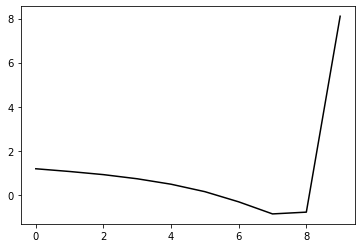

730100 0.20819856098060374
0.17412996302843714 -0.2219147881657681 0.1960571365064762 0.10140046449810775
[ 1.17944673  1.06838494  0.93217125  0.74446988  0.49469768  0.15519789
 -0.30760886 -0.85776591 -0.78146458  8.10520716]


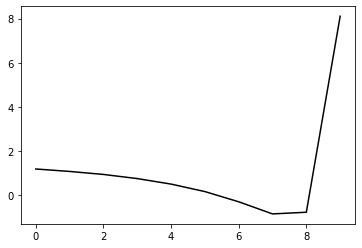

740100 0.15913112283518452
0.17668473796747883 -0.21691442264924687 0.19649521301135792 0.0997063246854009
[ 1.17666322  1.07435743  0.93851584  0.75448055  0.50625882  0.16661936
 -0.29653482 -0.84868715 -0.77713944  8.10451119]


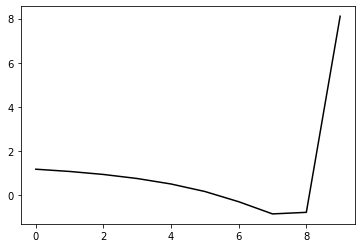

750100 0.23659652517733215
0.17511482404305734 -0.21147803954288613 0.19421196381756378 0.09618237120788282
[ 1.17464021  1.07465971  0.93763804  0.75631436  0.50967746  0.16970211
 -0.29454291 -0.84893213 -0.78183462  8.10419477]


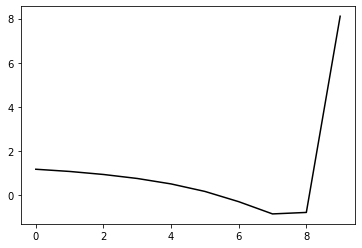

760100 0.1508063302148568
0.17832327789664024 -0.21238635145118362 0.19633073880541066 0.09545285427356572
[ 1.17197565  1.06635344  0.91761875  0.72685633  0.47637086  0.13389602
 -0.33383571 -0.89314459 -0.83314134  8.09490167]


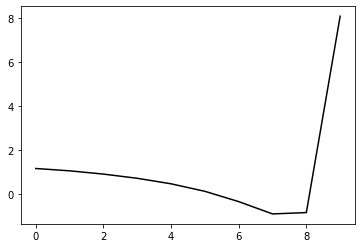

770100 0.18577653037922978
0.1817144663486871 -0.20928925221229705 0.19810742423197572 0.09776817500915175
[ 1.16853417  1.08289272  0.94321711  0.75280674  0.50062491  0.15824454
 -0.30885192 -0.86837387 -0.81012058  8.09883122]


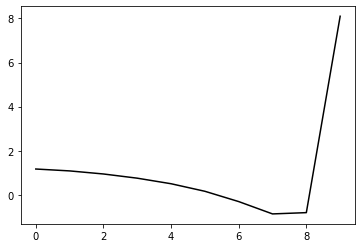

780100 0.40304910244965525
0.16542583824462645 -0.20807035124690898 0.19237375199959306 0.10764751410294111
[ 1.18042587  1.05637394  0.91837618  0.72882754  0.4756134   0.13086234
 -0.33842985 -0.90094287 -0.84730406  8.09362664]


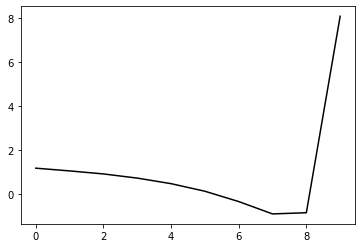

790100 0.1418937597175172
0.1745024219292483 -0.21569359548642172 0.20223636525733993 0.10180060841938395
[ 1.17056599  1.06093696  0.92137883  0.72978798  0.47563445  0.13042823
 -0.33917874 -0.90235688 -0.85052891  8.09261052]


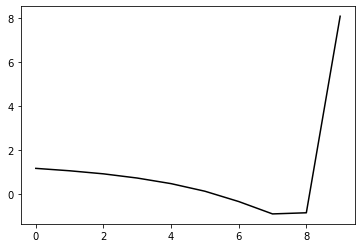

800100 0.18015303319548936
0.18094725856288177 -0.20885300549735167 0.20196054727518584 0.1008597390441965
[ 1.16510185  1.07579115  0.93852372  0.75004439  0.49664185  0.15072477
 -0.31989132 -0.88483902 -0.83679573  8.09356301]


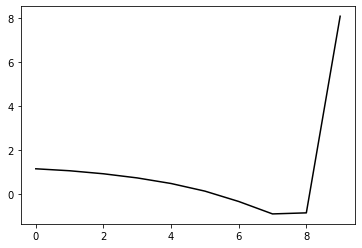

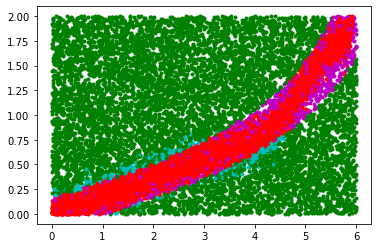

810100 0.20773140643020954
0.16503182718118925 -0.2105646421248822 0.20035652162434497 0.10518588572913054
[ 1.17520061  1.04909766  0.91204404  0.72658634  0.47621056  0.13107407
 -0.3403446  -0.90725324 -0.86326247  8.0916361 ]


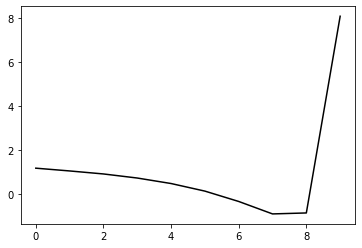

820100 0.17949709015528628
0.17725206465263482 -0.2012381899113861 0.20131560170658533 0.0949586950816369
[ 1.1646644   1.06628253  0.92858477  0.74151443  0.49050924  0.1454625
 -0.32741036 -0.89767422 -0.86001412  8.09134477]


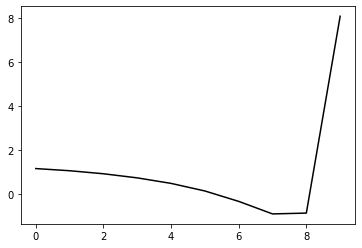

830100 0.24610838305509422
0.1725287161038877 -0.20355523311314777 0.20254856760895731 0.10233705094342092
[ 1.16794146  1.06848574  0.93184742  0.74383394  0.4921421   0.14723936
 -0.32565375 -0.89671716 -0.86088075  8.0919659 ]


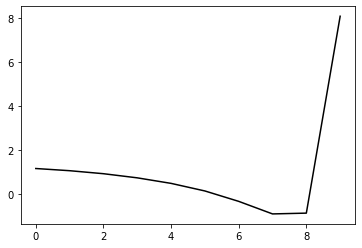

840100 0.25788011991027526
0.16468801289962692 -0.20818365474481304 0.20364273683065778 0.10454578366663914
[ 1.17178678  1.04745182  0.90782789  0.71943278  0.46676476  0.12041726
 -0.35404052 -0.92752832 -0.8953708   8.08282026]


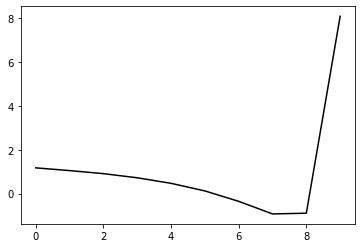

850100 0.24543303140645964
0.174656934278373 -0.19923323907182425 0.20373606693538698 0.09576207528755971
[ 1.16236755  1.06310715  0.92197271  0.73546932  0.48360342  0.13722889
 -0.3380061  -0.91376832 -0.88639182  8.08692398]


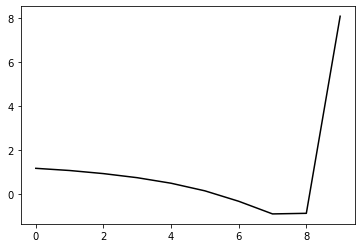

860100 0.2209025261317722
0.16911765616769062 -0.20562162557301944 0.20737400414191715 0.10389506636693417
[ 1.16660122  1.05934822  0.92034455  0.73206419  0.48038619  0.13480212
 -0.33978218 -0.91530794 -0.88834604  8.08633499]


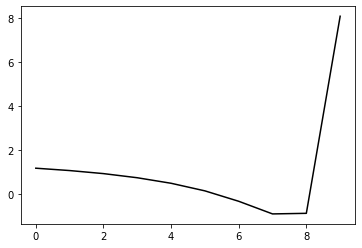

870100 0.16166301075047892
0.17407017812832118 -0.2016279560185256 0.20593668185146716 0.10199389040403409
[ 1.16303181  1.05200267  0.91094133  0.71934763  0.4642161   0.11544235
 -0.36257337 -0.94265784 -0.92216721  8.07954509]


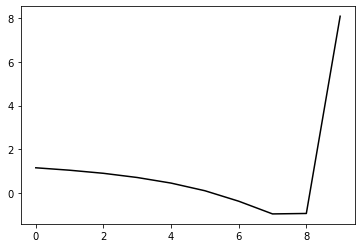

880100 0.23067609205788486
0.17392533109564723 -0.1986636880162728 0.2075403097324488 0.10235428912854949
[ 1.16207201  1.0646686   0.9257424   0.73665245  0.48323212  0.13579891
 -0.34121931 -0.92149218 -0.90323692  8.08322389]


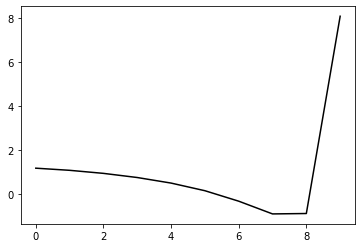

890100 0.22455158149578128
0.1720542735206569 -0.194404765632935 0.20637224382455227 0.10251698927662095
[ 1.16278026  1.05907294  0.92546415  0.73878405  0.48640815  0.13916683
 -0.33818434 -0.91986781 -0.90497342  8.08439404]


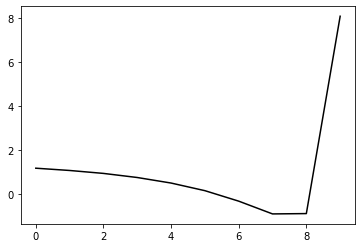

900100 0.1848210755329931
0.17040805648858703 -0.19699143300063893 0.20803356161469708 0.10521864978464651
[ 1.16198489  1.06277768  0.92854711  0.74181333  0.48979387  0.1424237
 -0.33539198 -0.91783537 -0.90446526  8.08563008]


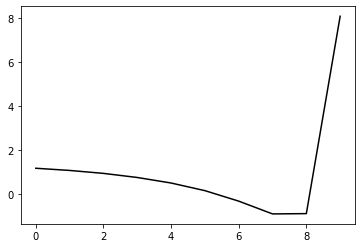

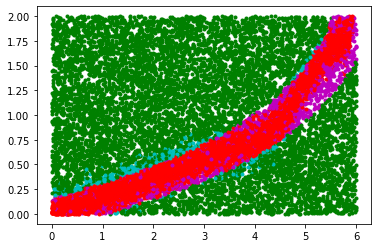

910100 0.23700865785005054
0.18321554591774755 -0.19152087557278571 0.20844791807849686 0.0970096369205851
[ 1.15124446  1.06127828  0.92297957  0.73516706  0.48194457  0.13225114
 -0.348826   -0.93574061 -0.92903931  8.07677128]


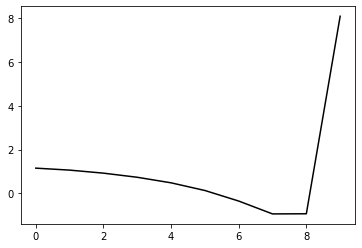

920100 0.20938248152587943
0.16462094976291988 -0.19794855881759632 0.2088167982183196 0.10184609081374295
[ 1.16310465  1.040643    0.89526251  0.70818706  0.45647244  0.1084807
 -0.37191846 -0.95930573 -0.95433602  8.07523803]


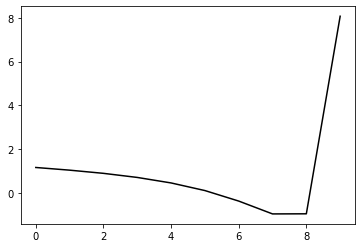

930100 0.24514653909574885
0.1634936499849091 -0.1904825174291927 0.2049690021955497 0.09923131112205558
[ 1.16218438  1.0410258   0.89860786  0.70823371  0.45456637  0.10564517
 -0.37617073 -0.96652929 -0.96669407  8.06979139]


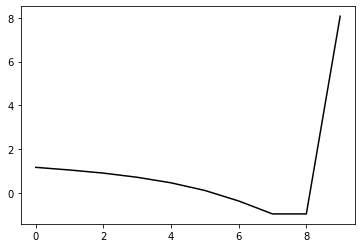

940100 0.2112512158958358
0.16117715201089933 -0.20014734751495558 0.2101640689343292 0.10854017655693497
[ 1.16503335  1.03389282  0.89336393  0.70168207  0.44448412  0.09352328
 -0.38935194 -0.98078048 -0.98184731  8.07015686]


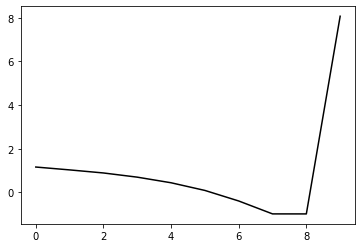

950100 0.2119768234314312
0.16421561052261135 -0.1978059987966948 0.2115039669937452 0.10683235807770003
[ 1.16134275  1.04370015  0.90242884  0.71103433  0.45448718  0.10290614
 -0.38055284 -0.97339939 -0.97757998  8.07166036]


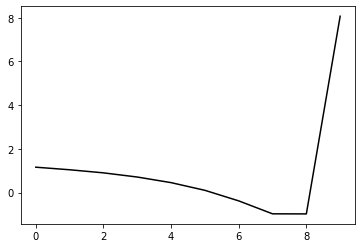

960100 0.22412048319046993
0.1636048161710332 -0.1962634414184155 0.21279192002057826 0.10787044516291235
[ 1.16070229  1.0449338   0.91222357  0.7263986   0.47245282  0.1223505
 -0.35987183 -0.95197081 -0.95678361  8.07597457]


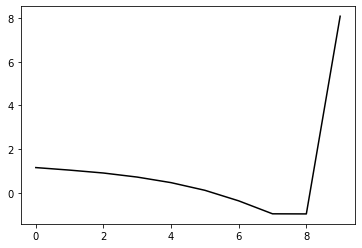

970100 0.1826824487012164
0.17110042755146784 -0.18628476405090458 0.20860282895432403 0.09833965229599066
[ 1.15308813  1.04910672  0.90620099  0.71732806  0.46201303  0.1095037
 -0.37634427 -0.97330958 -0.98529271  8.067319  ]


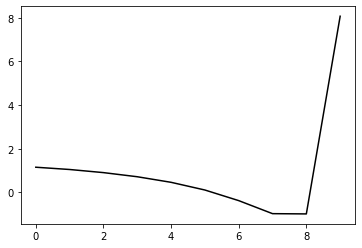

980100 0.08798796989012297
0.16591993847141753 -0.19115885919102446 0.20992862094725848 0.10371545022426448
[ 1.15678817  1.0294148   0.88782517  0.69937505  0.44359322  0.0901417
 -0.3973407  -0.99654792 -1.01173701  8.06734204]


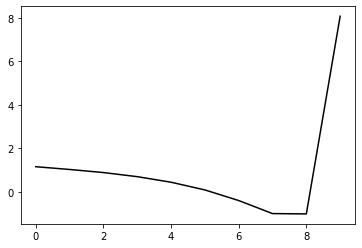

990100 0.21377968841891948
0.1767942457989818 -0.18170839929980254 0.2090333920430688 0.10356891212880144
[ 1.14929265  1.06466539  0.92525064  0.73193436  0.47426063  0.12063885
 -0.36741721 -0.96813928 -0.98632664  8.06860643]


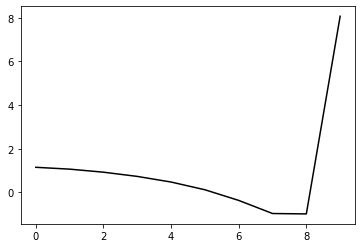

In [19]:
optimizer=tf.optimizers.Adam(learning_rate=0.0005)
for j in range (10000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta, Positive[j%set], Negative[j%set])
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
        if np.isnan(loss)==True: break
    for i in range (10):
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
        if any(np.isnan(h.numpy()))==True: break
    if j%100==0: 
        print((j+1)*100, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
        print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()
    if j%1000==0:
        for i in range (set):
            [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
            [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
        for i in range (set):
            x_data1[i]=[v[0] for v in Positive0[i]]
            y_data1[i]=[v[1] for v in Positive0[i]]
            x_data2[i]=[v[0] for v in Positive1[i]]
            y_data2[i]=[v[1] for v in Positive1[i]]
            x_data3[i]=[v[0] for v in Negative0[i]]
            y_data3[i]=[v[1] for v in Negative0[i]]
            x_data4[i]=[v[0] for v in Negative1[i]]
            y_data4[i]=[v[1] for v in Negative1[i]]
            plt.plot(x_data4[i], y_data4[i], 'g.')
            plt.plot(x_data2[i], y_data2[i], 'c.')
            plt.plot(x_data1[i], y_data1[i], 'r.')
            plt.plot(x_data3[i], y_data3[i], 'm.')
        plt.show()

0 0.3235065135279091
0.15862361892490562 -0.18671732621377024 0.2074740158800178 0.1061674534476626
[ 1.20143062  1.07580476  0.93437814  0.74383889  0.48660801  0.13259573
 -0.35588646 -0.95785963 -1.07824152  8.02526007]


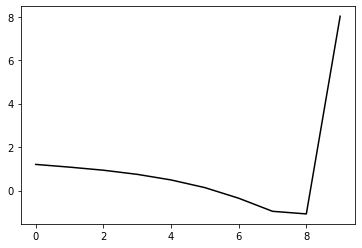

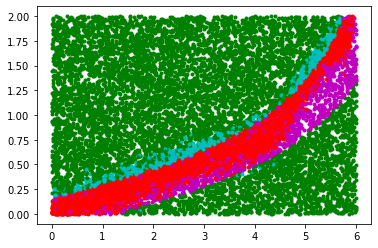

1000 0.23467345277961646
0.1693206707416885 -0.1873442758748339 0.21011456015936816 0.103405020799329
[ 1.21419746  1.0882029   0.96626613  0.80077117  0.55682121  0.18824951
 -0.34383299 -1.01912732 -1.20593843  7.98628538]


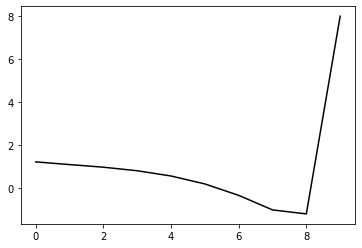

2000 0.21831710163679485
0.1713669161654212 -0.1876578609611121 0.21184044900137552 0.10252911420954709
[ 1.20702647  1.17213733  1.04824337  0.85518757  0.60446211  0.25697648
 -0.25081495 -0.93214687 -1.1312721   8.07758398]


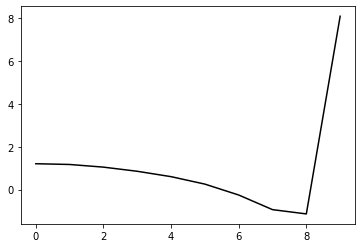

3000 0.24402633038440188
0.17337758571235637 -0.184099155573182 0.20983738862233733 0.10142307208911001
[ 1.22197726  1.09437812  0.97132297  0.80418556  0.55973754  0.19687663
 -0.32665593 -1.02090059 -1.24865922  7.99660948]


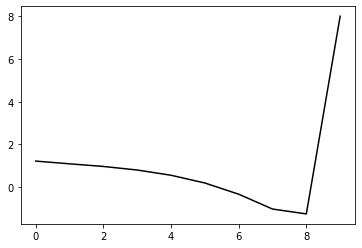

4000 0.23018820396752546
0.1708158516096558 -0.19040132168256688 0.21464353967776614 0.09780415551915024
[ 1.2072987   1.14696103  1.05114773  0.88550603  0.6478069   0.29876151
 -0.21164431 -0.90192023 -1.13639345  8.05222639]


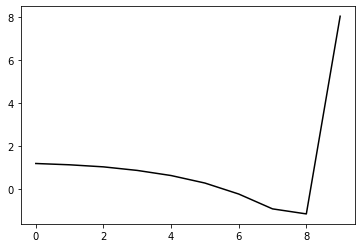

5000 0.1573439832007384
0.16761609025725172 -0.18369101134342916 0.20992559631609486 0.09682469001453878
[ 1.23733301  1.14474941  1.03287778  0.85797473  0.60373829  0.24506599
 -0.26995688 -0.95904649 -1.20603166  8.04684411]


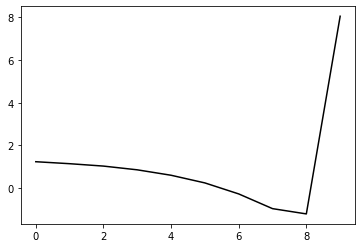

6000 0.283456036698889
0.16763107954219061 -0.18809165246364562 0.21173297812240266 0.09734678491119689
[ 1.21736173  1.09476053  0.93075722  0.73162294  0.47173924  0.0966813
 -0.43997811 -1.14827915 -1.40468061  7.98837228]


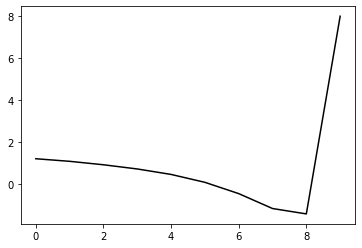

7000 0.1595549942497138
0.1753393647191292 -0.18426190304185475 0.21103419191986025 0.0950286206795889
[ 1.23039126  1.21670444  1.15713411  1.01171392  0.78110103  0.42929324
 -0.10081782 -0.82429223 -1.10369938  8.07787319]


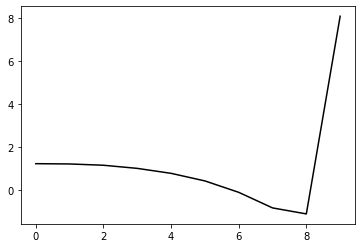

8000 0.13900401896878967
0.17566953491643927 -0.19123643915432084 0.21359988695624832 0.09591160074480702
[ 1.22483551  1.17284008  1.0558032   0.88051489  0.63026441  0.26195569
 -0.26202049 -0.96965928 -1.24245914  8.01889605]


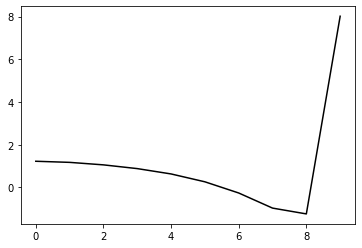

9000 0.2433241050413633
0.17327827517518657 -0.1836129522785791 0.20822731178719875 0.09494075833501894
[ 1.2011806   1.22374092  1.14477644  0.9792021   0.73946442  0.38856204
 -0.13302495 -0.85561246 -1.16885537  8.04304109]


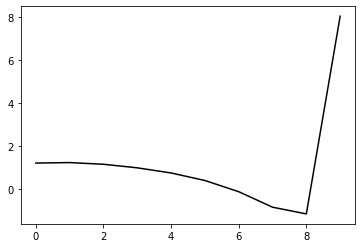

10000 0.15127706965629267
0.16931918314927405 -0.1866303904413481 0.20890158367246037 0.09540498316153785
[ 1.22587482  1.14888951  1.05199076  0.90537494  0.67862375  0.33848536
 -0.16932373 -0.87661846 -1.18082965  8.0155335 ]


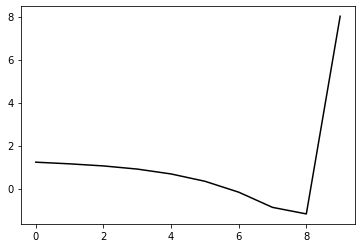

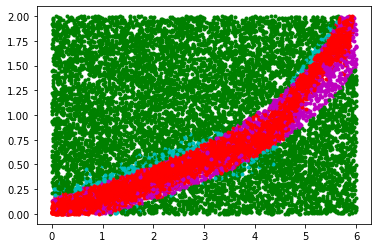

11000 0.15286171961336248
0.16854990435589923 -0.19429028619557925 0.21274603113601928 0.09595795557627441
[ 1.20852407  1.1154479   0.9570106   0.75924618  0.50935491  0.15359124
 -0.35607205 -1.05451805 -1.35225077  7.99617152]


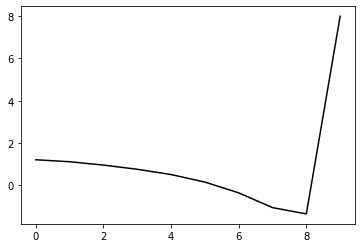

12000 0.30313311146109856
0.16785495127222502 -0.19395668981451117 0.2142943940389073 0.09516956966388287
[ 1.20528101  1.20538685  1.10926775  0.95508135  0.73966031  0.41731284
 -0.07134155 -0.7556609  -1.04882799  8.0781586 ]


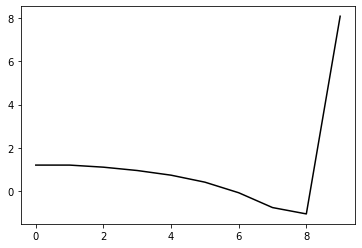

13000 0.1885529375627635
0.1686022491661993 -0.187093475299183 0.21001796323527702 0.09383727469996236
[ 1.2096326   1.22024757  1.13006884  0.96601193  0.72977945  0.39051599
 -0.1005949  -0.78320944 -1.09243449  8.06182056]


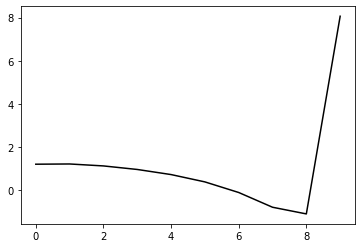

14000 0.2067426482363348
0.16551722953351025 -0.1954299688846692 0.21534833414095728 0.09163570165064681
[ 1.24887326  1.20348367  1.10266691  0.94721062  0.72596718  0.40232333
 -0.07666772 -0.73856072 -1.01666833  8.07934131]


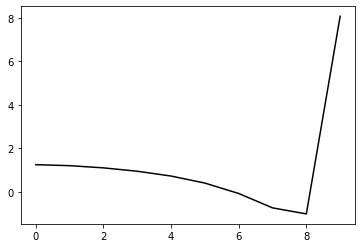

15000 0.24291254436159374
0.17211761943939793 -0.18739266701879015 0.21101429360069837 0.08858132730966557
[ 1.24233195  1.15189047  1.03039463  0.86628981  0.63564056  0.29763148
 -0.20383025 -0.9012897  -1.22642794  8.04742097]


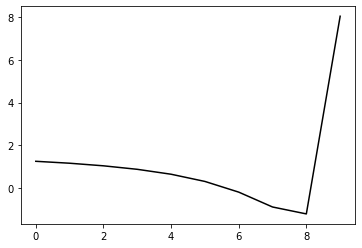

16000 0.24692327044294046
0.17125126061922677 -0.1956239463449536 0.2144232377973735 0.09164823788156515
[ 1.24474695  1.24130092  1.13364801  0.97165395  0.75116569  0.42130551
 -0.07766905 -0.76559891 -1.06100099  8.05263419]


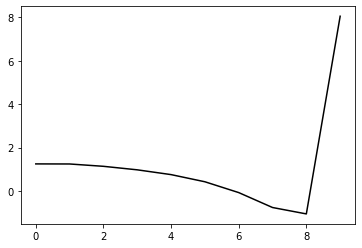

17000 0.18951379777976582
0.17102278467409945 -0.19636854199422563 0.2147817100659705 0.09047877657101039
[ 1.27230373  1.25666291  1.13655859  0.97513665  0.74859818  0.41288573
 -0.08720583 -0.77851827 -1.078958    8.09049295]


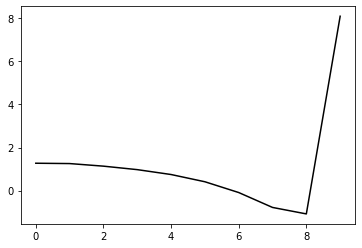

18000 0.18253068946963527
0.1729223746668064 -0.189530357680303 0.21119355083199795 0.09053673082162056
[ 1.31686065  1.25485021  1.1439884   0.97394964  0.75247388  0.4258475
 -0.0773171  -0.78854593 -1.11872651  8.05236419]


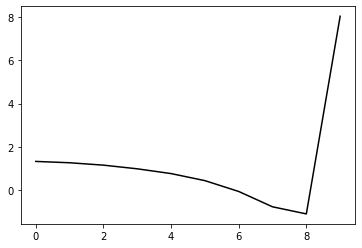

19000 0.26202893119045917
0.1746493863885583 -0.19471355452725023 0.21575832429443562 0.08728638549754027
[ 1.28035668  1.28263141  1.17812813  1.01866353  0.80227406  0.47546114
 -0.02182561 -0.72021651 -1.04386535  8.0608301 ]


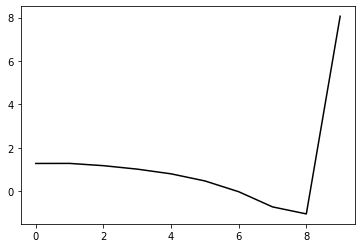

20000 0.2599086538541356
0.1760408357924697 -0.1934161368738788 0.2147486024849921 0.08815950992674251
[ 1.26256365  1.31548775  1.22070676  1.06258855  0.84271485  0.51660888
  0.02513906 -0.67016074 -0.99928358  8.07345909]


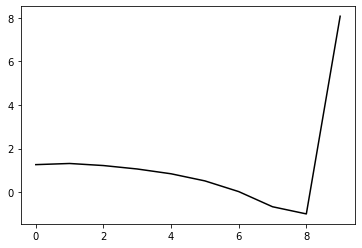

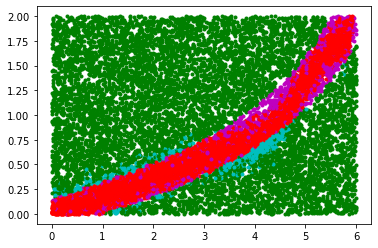

21000 0.2562423382820191
0.17369883379545584 -0.19265388972740868 0.2119178481553144 0.09062333743773963
[ 1.34672912  1.18125603  1.09565558  0.93754773  0.71217357  0.36594717
 -0.14570695 -0.84042507 -1.15200544  8.03250732]


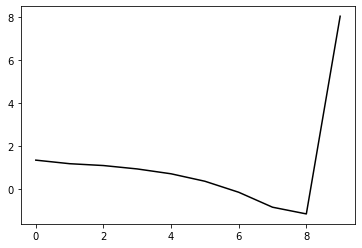

22000 0.2191960862390807
0.17282180535371508 -0.19423411474626018 0.21312865619030574 0.08890389778178927
[ 1.27759906  1.2738427   1.15639461  0.97837367  0.74541599  0.41491109
 -0.07680575 -0.77359052 -1.09965029  8.06078826]


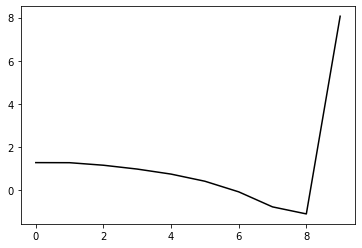

23000 0.21969747072126947
0.17327709669281968 -0.19121805086226762 0.21136102968231515 0.08468624417562692
[ 1.24896726  1.19407514  1.07026543  0.91161515  0.68557925  0.3354456
 -0.18797951 -0.91057186 -1.27247281  8.02795341]


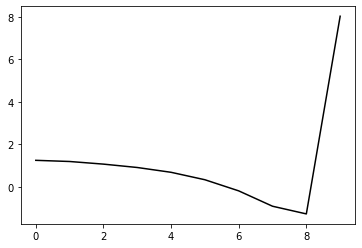

24000 0.23136434674819897
0.17106285671442195 -0.1934651058707563 0.21193193205671365 0.08745106469956059
[ 1.30493938  1.21384284  1.12744776  0.98291745  0.77272696  0.45534145
 -0.02900165 -0.71748665 -1.04633143  8.08102088]


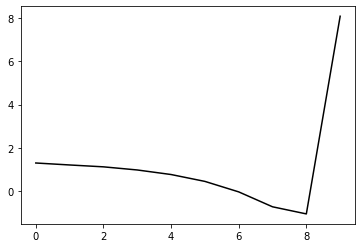

25000 0.1519602806156518
0.1719957108515438 -0.18810583213597457 0.207668330521335 0.08992727078382332
[ 1.23670392  1.25232276  1.19304483  1.05205975  0.82533461  0.48177299
 -0.02874866 -0.74601231 -1.11787004  8.02264144]


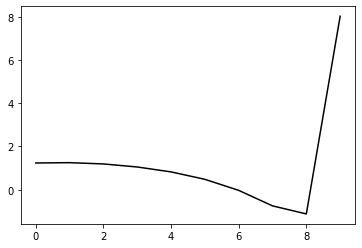

26000 0.23215912148526838
0.16395620632133096 -0.19798837632053412 0.21298733967189584 0.08945178263754654
[ 1.27236998  1.17972186  1.06278128  0.92284775  0.72473792  0.42229923
 -0.04373813 -0.71869622 -1.04879154  8.04898269]


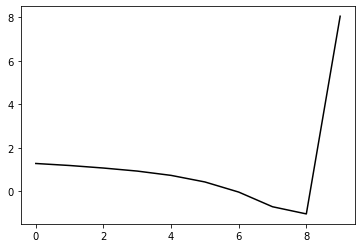

27000 0.257156539737167
0.1643480502009791 -0.19759683337253792 0.21267153680929132 0.08928511679269716
[ 1.24701682  1.22315564  1.12039518  0.96247757  0.74286552  0.42497171
 -0.04528663 -0.70877563 -1.02696523  8.07106332]


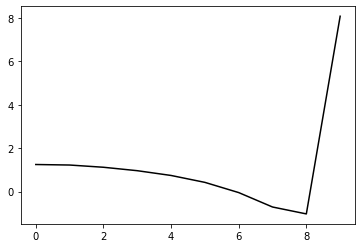

28000 0.1785504762204968
0.17102169321735572 -0.1867321860251242 0.20762851925314604 0.08779711208959451
[ 1.25504125  1.26921567  1.20725239  1.05169028  0.81583345  0.47528407
 -0.02139699 -0.70142701 -1.01972011  8.06237071]


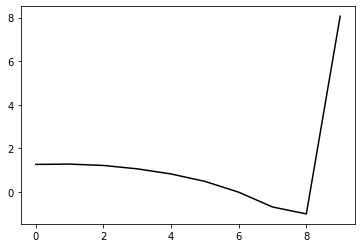

29000 0.2174353799106794
0.17204700098238912 -0.19268952552521185 0.20996096207010856 0.0880999674240338
[ 1.27098305  1.22491557  1.12607165  0.96119299  0.718978    0.37342199
 -0.12161246 -0.79275079 -1.07683355  8.10419303]


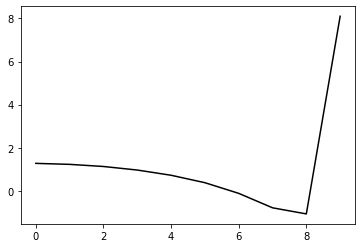

30000 0.20337550418263822
0.17170437862953872 -0.19683958259399276 0.21258408090722328 0.08705619823466088
[ 1.25502639  1.2119495   1.1045094   0.94474818  0.738584    0.42202357
 -0.06272935 -0.72677765 -0.98684149  8.06359399]


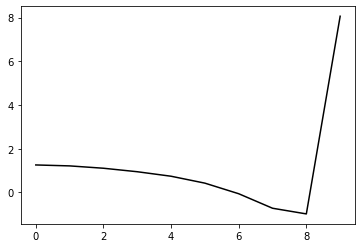

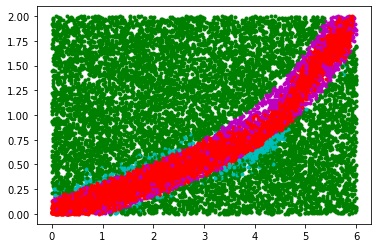

31000 0.18693336283649403
0.16976793985323044 -0.19495506444639396 0.21047561853393604 0.08516687276215444
[ 1.28629172  1.22011644  1.11297411  0.94590509  0.72346374  0.40121326
 -0.07950099 -0.74622074 -1.02320414  8.05388455]


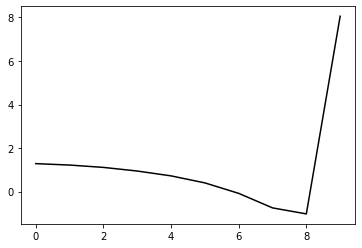

32000 0.33495485661763746
0.16974893837606747 -0.19275008547379618 0.20885565430014716 0.08806934044879373
[ 1.32596816  1.2516396   1.15553069  1.00069693  0.77031286  0.42750036
 -0.07210512 -0.74428145 -1.01842888  8.07721466]


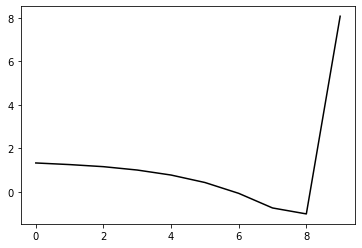

33000 0.21752670595423243
0.17966059583957802 -0.19124704125210112 0.20949051867969087 0.08822690912968122
[ 1.28418832  1.32799121  1.23630969  1.06054499  0.8106806   0.45066336
 -0.07725117 -0.79608502 -1.10353879  8.05490412]


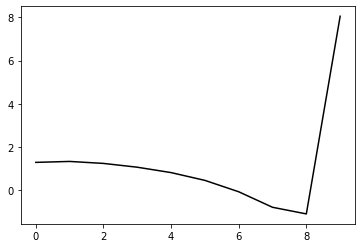

34000 0.19868460758669354
0.17832654840569512 -0.19719353599304265 0.21346466104739964 0.08585899196825379
[ 1.28140481  1.21731968  1.0868169   0.9242523   0.70054351  0.36654905
 -0.13486824 -0.83824077 -1.13916285  8.04777572]


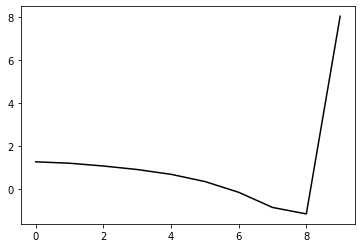

35000 0.26882226226061906
0.1767920420227186 -0.19886248627270275 0.21273321820151536 0.0893710366700501
[ 1.32619595  1.21912657  1.05249467  0.85910688  0.61310626  0.26018206
 -0.26297051 -0.9870583  -1.31959063  7.99968222]


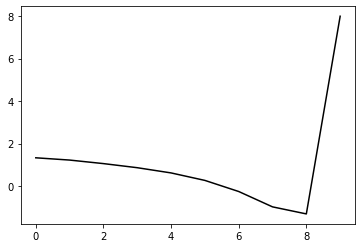

36000 0.2236645327337299
0.18179339164165317 -0.19194598974415888 0.21089621690741117 0.0865153640359824
[ 1.28550255e+00  1.32281344e+00  1.22195845e+00  1.05751896e+00
  8.35138639e-01  5.04413261e-01 -4.70609890e-03 -7.34203288e-01
 -1.09720419e+00  8.02657455e+00]


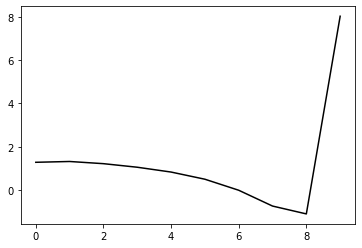

37000 0.18342208476145427
0.18085808937957443 -0.19374802436145838 0.21098470842806674 0.08626536937906437
[ 1.28940511  1.23663392  1.12230078  0.95170092  0.71529655  0.37281467
 -0.12891631 -0.82752648 -1.16501834  8.03588749]


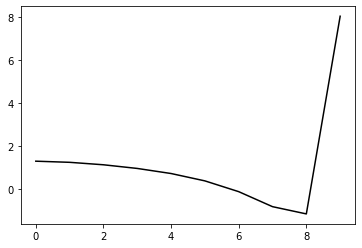

38000 0.21087149984349254
0.17890447233789908 -0.19840623298983115 0.21359964845131613 0.08537012104569146
[ 1.34135418  1.27916981  1.13691997  0.93209999  0.68855075  0.34978741
 -0.14843975 -0.84118365 -1.17045596  8.03441789]


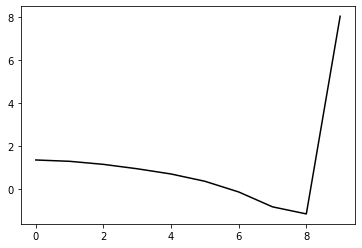

39000 0.13470393672393438
0.18248350452968287 -0.19221460951043082 0.21027976234455148 0.08657807153877378
[ 1.30236477e+00  1.30439269e+00  1.22872647e+00  1.08183136e+00
  8.57102476e-01  5.15834565e-01  2.80012388e-03 -7.07341115e-01
 -1.04795476e+00  8.05602945e+00]


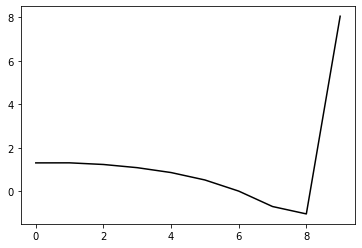

40000 0.1657955332209066
0.18637550037911318 -0.19617413058160765 0.21332814884293688 0.08812669684629541
[ 1.29704955  1.26370406  1.16562483  0.99822935  0.75421347  0.3943875
 -0.1310104  -0.8484056  -1.17795465  8.04586833]


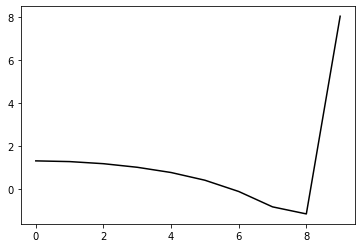

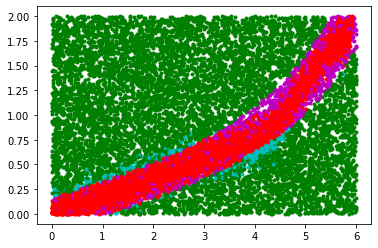

41000 0.19025534209133788
0.18323958188539513 -0.1945486548181786 0.21150861738008694 0.09242433200872784
[ 1.30599053  1.27491819  1.17332676  1.01438251  0.78336706  0.43244064
 -0.09761375 -0.82405443 -1.15266795  8.06604164]


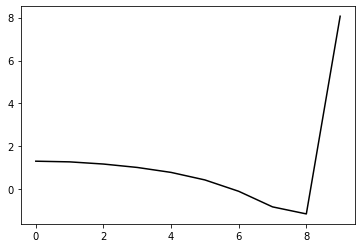

42000 0.18084382570891594
0.1801636889886647 -0.1992971682800553 0.2124644191297675 0.08975815703405556
[ 1.33391598  1.18448308  0.97690811  0.77906201  0.54241123  0.19304853
 -0.33597507 -1.07669335 -1.43277495  7.98268088]


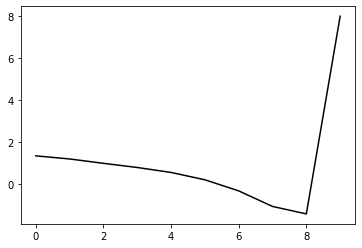

43000 0.19244195885803128
0.18643086228828235 -0.19274621376615628 0.2107610745180956 0.08766494328367196
[ 1.280951    1.32375921  1.22488271  1.06239678  0.84068453  0.4994796
 -0.0278706  -0.76676175 -1.13097497  8.03632631]


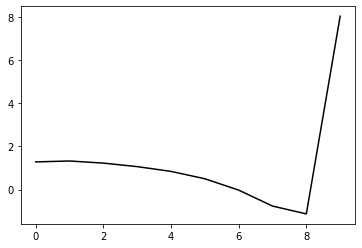

44000 0.19750138209771376
0.18383717287098297 -0.18983277550702587 0.20785556659981888 0.08914395682540495
[ 1.26405223  1.27651974  1.16588032  1.00902527  0.79205169  0.45218267
 -0.06734917 -0.7940997  -1.15360612  7.99219606]


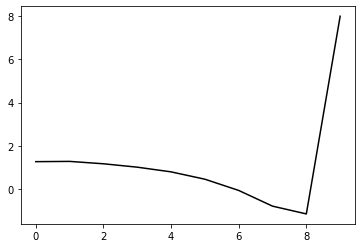

45000 0.22781559229114257
0.17901750764237873 -0.19169900872807294 0.20675960150813902 0.09198137101674
[ 1.27817932  1.20038515  1.09598824  0.94354067  0.72614155  0.39449913
 -0.1181792  -0.84175409 -1.20016239  8.05237215]


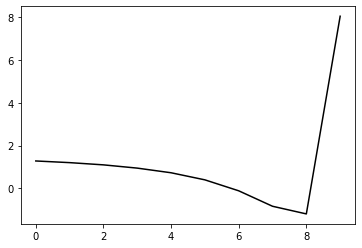

46000 0.20329355970822913
0.1763220267762577 -0.202669340030094 0.2125262851264122 0.09161631640064537
[ 1.27022842  1.23641794  1.1215628   0.94980938  0.71467489  0.37619593
 -0.1196552  -0.81113895 -1.13179203  8.04432044]


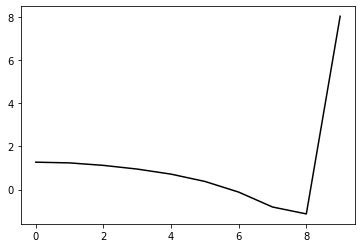

47000 0.14983014784840304
0.18094709057677494 -0.19535063657081644 0.207427007109431 0.09132090585093423
[ 1.2549359   1.20305051  1.1086389   0.94182888  0.69644827  0.32959922
 -0.21457963 -0.95315991 -1.30866991  8.02519777]


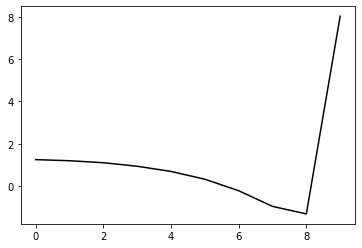

KeyboardInterrupt: 

In [20]:
optimizer=tf.optimizers.Adam(learning_rate=0.0005)
for j in range (10000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta, Positive[j%set], Negative[j%set])
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
        if np.isnan(loss)==True: break
    for i in range (90):
        optimizer.apply_gradients(zip(gradients, [h]))
        if any(np.isnan(h.numpy()))==True: break
    for i in range (10):
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
        if any(np.isnan(h.numpy()))==True: break
    if j%100==0: 
        print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
        print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()
    if j%1000==0:
        for i in range (set):
            [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
            [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
        for i in range (set):
            x_data1[i]=[v[0] for v in Positive0[i]]
            y_data1[i]=[v[1] for v in Positive0[i]]
            x_data2[i]=[v[0] for v in Positive1[i]]
            y_data2[i]=[v[1] for v in Positive1[i]]
            x_data3[i]=[v[0] for v in Negative0[i]]
            y_data3[i]=[v[1] for v in Negative0[i]]
            x_data4[i]=[v[0] for v in Negative1[i]]
            y_data4[i]=[v[1] for v in Negative1[i]]
            plt.plot(x_data4[i], y_data4[i], 'g.')
            plt.plot(x_data2[i], y_data2[i], 'c.')
            plt.plot(x_data1[i], y_data1[i], 'r.')
            plt.plot(x_data3[i], y_data3[i], 'm.')
        plt.show()

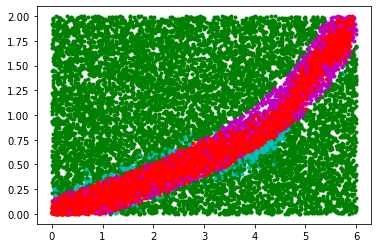

In [21]:
for i in range (set):
    [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
    [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
for i in range (set):
    x_data1[i]=[v[0] for v in Positive0[i]]
    y_data1[i]=[v[1] for v in Positive0[i]]
    x_data2[i]=[v[0] for v in Positive1[i]]
    y_data2[i]=[v[1] for v in Positive1[i]]
    x_data3[i]=[v[0] for v in Negative0[i]]
    y_data3[i]=[v[1] for v in Negative0[i]]
    x_data4[i]=[v[0] for v in Negative1[i]]
    y_data4[i]=[v[1] for v in Negative1[i]]
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()

47540 0.15268361525207524
0.17917477097041265 -0.20026457048282886 0.21001364483406615 0.0922668218949636
[ 1.22400923  1.18792222  1.08304131  0.91367737  0.67923722  0.33225145
 -0.19532472 -0.93124304 -1.27993853  7.96945046]


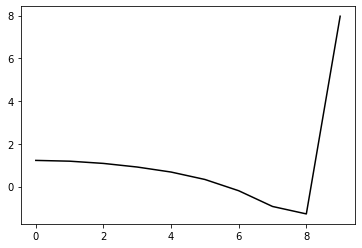

([<matplotlib.lines.Line2D at 0x1d32ebbc0c8>], None)

In [22]:
print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
plt.plot(h.numpy(), 'k-'), plt.show()